# Exemplo Detalhado de Uso - Cluster Fácil

Este notebook demonstra os passos essenciais e funcionalidades adicionais da biblioteca `cluster-facil`.

## 1. Instalação

Se você ainda não instalou a biblioteca, descomente e execute a célula abaixo. Ela instalará a versão mais recente diretamente do repositório GitHub.

In [1]:
# !pip install git+https://github.com/bdcdo/cluster-facil.git
# 
# # Instale também dependências opcionais se for usar:
# !pip install matplotlib openpyxl pyarrow

## 2. Importações e Dados de Exemplo

Vamos importar o `pandas` para criar nosso DataFrame de exemplo e a classe `ClusterFacil` da nossa biblioteca.

In [2]:
import pandas as pd
from cluster_facil import ClusterFacil
from dotenv import load_dotenv
load_dotenv(override=True)  # Isso carrega as variáveis do .env para o ambiente

# Criando um DataFrame de exemplo simples com textos
data = {'id': [1, 2, 3, 4, 5, 6, 7, 8],
        'texto_documento': [
            "O juiz determinou o pagamento da indenização.",
            "Recurso de apelação foi interposto pela defesa.",
            "A sentença julgou procedente o pedido do autor.",
            "A corte negou provimento ao recurso especial.",
            "Processo arquivado por falta de movimentação.",
            "Acordo homologado entre as partes.",
            "Indenização por danos morais foi concedida.",
            "Extinção do processo sem resolução de mérito."
        ]}

In [3]:
df_exemplo = pd.DataFrame(data)

print("DataFrame de Exemplo:")
display(df_exemplo)

DataFrame de Exemplo:


,id,texto_documento
0,1,O juiz determinou o pagamento da indenização.
1,2,Recurso de apelação foi interposto pela defesa.
2,3,A sentença julgou procedente o pedido do autor.
3,4,A corte negou provimento ao recurso especial.
4,5,Processo arquivado por falta de movimentação.
5,6,Acordo homologado entre as partes.
6,7,Indenização por danos morais foi concedida.
7,8,Extinção do processo sem resolução de mérito.


## 3. Inicializando o ClusterFacil

Criamos uma instância da classe, passando nosso DataFrame.
Usamos `random_state=42` para garantir que os resultados da clusterização sejam reprodutíveis.

In [4]:
cf = ClusterFacil(df_exemplo, random_state=42)

2025-04-21 22:59:39,165 - INFO - ClusterFacil iniciado com um DataFrame já existente.
2025-04-21 22:59:39,169 - INFO - Próxima rodada de clusterização definida como: 1


## 4. Preparando os Dados e Analisando o Cotovelo

Chamamos o método `preparar`. Ele fará o pré-processamento (TF-IDF) e **exibirá o gráfico do método do cotovelo** (se `matplotlib` estiver instalado e `plotar_cotovelo=True`, que é o padrão).

Precisamos informar:
*   `coluna_textos`: O nome da coluna que contém os textos.
*   `limite_k` (opcional): O número máximo de clusters (K) a testar no método do cotovelo (padrão é 10).

2025-04-21 22:59:39,175 - INFO - Iniciando preparação dos textos para agrupamento (rodada 1). Coluna de texto: 'texto_documento', limite de grupos para teste: 5.
2025-04-21 22:59:39,175 - INFO - Analisando características de 8 textos (TF-IDF)...
2025-04-21 22:59:39,182 - INFO - Análise TF-IDF concluída. 8 textos processados, 30 características (palavras/termos) identificadas.
2025-04-21 22:59:39,182 - INFO - Avaliando diferentes números de grupos (método do cotovelo)...
2025-04-21 22:59:39,183 - INFO - Calculando opções de agrupamento (inércias) para K de 1 a 5...


Iniciando a preparação e geração do gráfico do cotovelo...


Avaliando número de grupos (K): 100%|██████████| 5/5 [00:00<00:00, 20.80K/s]
2025-04-21 22:59:39,425 - INFO - Cálculo das opções de agrupamento (inércias) concluído.
2025-04-21 22:59:39,427 - WARNING - O gráfico do cotovelo pode estar incompleto devido a erros no cálculo de alguns valores de K (exibindo 4 pontos).
2025-04-21 22:59:39,865 - INFO - Gerando gráfico do cotovelo para visualização...
2025-04-21 22:59:39,885 - INFO - Exibindo gráfico do cotovelo...


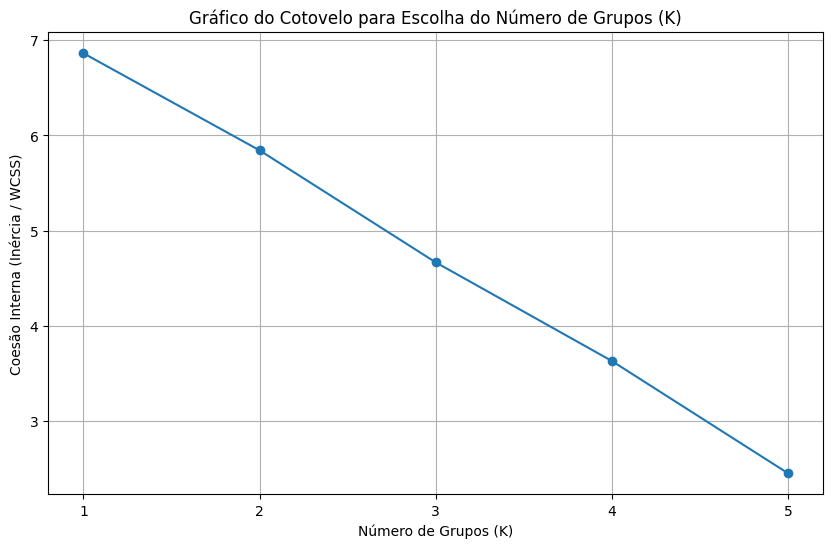

2025-04-21 22:59:39,968 - INFO - Preparação da rodada 1 concluída. Analise o gráfico do cotovelo (baseado em 8 textos) para escolher o número de grupos (K).


Preparação concluída.


In [5]:
print("Iniciando a preparação e geração do gráfico do cotovelo...")
cf.preparar(coluna_textos='texto_documento', limite_k=5)
print("Preparação concluída.")

### Analisando o Gráfico do Cotovelo

Olhe o gráfico gerado acima. O eixo Y mostra a inércia (WCSS - Within-Cluster Sum of Squares) e o eixo X mostra o número de clusters (K).

Procure por um "cotovelo" (elbow) na curva: um ponto onde a taxa de diminuição da inércia desacelera significativamente. Adicionar mais clusters depois desse ponto geralmente não traz um ganho tão grande na separação dos grupos.

**Neste exemplo, o cotovelo parece estar em K=3.**

## 5. Clusterizando

Agora que escolhemos nosso K (K=3), vamos executar a clusterização com o método `clusterizar`.

In [6]:
k_escolhido = 3
print(f"Executando a clusterização com K={k_escolhido}...")
nome_coluna_cluster = cf.clusterizar(num_clusters=k_escolhido)
print(f"Clusterização concluída. Coluna '{nome_coluna_cluster}' adicionada ao DataFrame.")

2025-04-21 22:59:39,975 - INFO - Iniciando agrupamento (clusterização) em 3 grupos para a rodada 1 (prefixo: 'cluster_').
2025-04-21 22:59:39,975 - INFO - Agrupando 8 textos em 3 grupos (K-Means)...
2025-04-21 22:59:39,975 - INFO - Agrupamento K-Means concluído. 8 textos foram atribuídos a grupos.
2025-04-21 22:59:39,983 - INFO - Coluna de resultados 'cluster_1' adicionada/atualizada.
2025-04-21 22:59:39,983 - INFO - Agrupamento da rodada 1 (prefixo 'cluster_') concluído com sucesso. Resultados na coluna 'cluster_1'.


Executando a clusterização com K=3...
Clusterização concluída. Coluna 'cluster_1' adicionada ao DataFrame.


## 6. Verificando o Resultado da Clusterização

O DataFrame original dentro do objeto `cf` agora possui a nova coluna (ex: `cluster_1`) com o ID do cluster atribuído a cada documento.

In [7]:
print("DataFrame com a coluna de cluster:")
display(cf.df[['id', nome_coluna_cluster, 'texto_documento']])

DataFrame com a coluna de cluster:


,id,cluster_1,texto_documento
0,1,2,O juiz determinou o pagamento da indenização.
1,2,2,Recurso de apelação foi interposto pela defesa.
2,3,0,A sentença julgou procedente o pedido do autor.
3,4,2,A corte negou provimento ao recurso especial.
4,5,1,Processo arquivado por falta de movimentação.
5,6,2,Acordo homologado entre as partes.
6,7,2,Indenização por danos morais foi concedida.
7,8,1,Extinção do processo sem resolução de mérito.


## 7. Salvando os Resultados

Podemos salvar o DataFrame completo e/ou amostras de cada cluster usando o método `salvar`.

In [8]:
print("Salvando os resultados...")
status_salvar = cf.salvar(
    o_que_salvar='ambos',      # Salva o DF completo e as amostras
    formato_tudo='csv',        # Salva o DF completo como CSV
    formato_amostras='xlsx',   # Salva as amostras como Excel (requer openpyxl)
    # caminho_tudo='output/meu_df_completo.csv', # Opcional: caminho específico
    # caminho_amostras='output/minhas_amostras.xlsx', # Opcional: caminho específico
    # diretorio_saida='output/' # Opcional: diretório para nomes padrão
)

print("\nStatus do salvamento:")
print(status_salvar)

if status_salvar.get('tudo_salvo'):
    print(f"- DataFrame completo salvo em: {status_salvar.get('caminho_tudo')}")
if status_salvar.get('amostras_salvas'):
    print(f"- Amostras salvas em: {status_salvar.get('caminho_amostras')}")

2025-04-21 22:59:40,007 - INFO - Iniciando processo para salvar resultados (Opção: 'ambos', Prefixo: 'cluster_')...
2025-04-21 22:59:40,010 - INFO - Usando caminho padrão para o arquivo completo: .\resultados_cluster_cluster_rodada1.csv


Salvando os resultados...


2025-04-21 22:59:40,395 - INFO - Usando caminho padrão para o arquivo de amostras: .\resultados_cluster_cluster_amostras_rodada1.xlsx
2025-04-21 22:59:40,395 - INFO - Salvando dados em 'resultados_cluster_cluster_rodada1.csv' (Formato: csv)...
2025-04-21 22:59:40,399 - INFO - Dados salvos com sucesso em: 'c:\Users\julio\OneDrive\Documentos\insper\cluster-facil\examples\resultados_cluster_cluster_rodada1.csv'.
2025-04-21 22:59:40,400 - INFO - Gerando e salvando arquivo de exemplos (até 10 por grupo) em 'resultados_cluster_cluster_amostras_rodada1.xlsx' (Formato: xlsx)...
2025-04-21 22:59:40,402 - INFO - Salvando dados em 'resultados_cluster_cluster_amostras_rodada1.xlsx' (Formato: xlsx)...
2025-04-21 22:59:40,415 - INFO - Dados salvos com sucesso em: 'c:\Users\julio\OneDrive\Documentos\insper\cluster-facil\examples\resultados_cluster_cluster_amostras_rodada1.xlsx'.
2025-04-21 22:59:40,417 - INFO - Processo de salvamento concluído. Status: {'tudo_salvo': True, 'caminho_tudo': 'c:\\Users\


Status do salvamento:
{'tudo_salvo': True, 'caminho_tudo': 'c:\\Users\\julio\\OneDrive\\Documentos\\insper\\cluster-facil\\examples\\resultados_cluster_cluster_rodada1.csv', 'amostras_salvas': True, 'caminho_amostras': 'c:\\Users\\julio\\OneDrive\\Documentos\\insper\\cluster-facil\\examples\\resultados_cluster_cluster_amostras_rodada1.xlsx'}
- DataFrame completo salvo em: c:\Users\julio\OneDrive\Documentos\insper\cluster-facil\examples\resultados_cluster_cluster_rodada1.csv
- Amostras salvas em: c:\Users\julio\OneDrive\Documentos\insper\cluster-facil\examples\resultados_cluster_cluster_amostras_rodada1.xlsx


## 8. Classificando Clusters

Após analisar as amostras ou o DataFrame completo, podemos atribuir rótulos (classificações) aos clusters usando o método `classificar`.

Isso cria/atualiza a coluna definida em `nome_coluna_classificacao` (padrão: 'classificacao').

In [9]:
# Supondo que, após análise, o cluster 0 e 2 são 'Procedente/Indenização'
# e o cluster 1 é 'Recurso/Extinção'
cf.classificar(cluster_ids=[0, 2], classificacao='Procedente/Indenização')
cf.classificar(cluster_ids=1, classificacao='Recurso/Extinção')

print("DataFrame com a coluna de classificação:")
# Exibindo colunas relevantes
display(cf.df[['id', nome_coluna_cluster, cf.nome_coluna_classificacao, 'texto_documento']])

2025-04-21 22:59:40,425 - INFO - Iniciando atribuição da classificação 'Procedente/Indenização' para o(s) grupo(s) [0, 2] da última rodada.
2025-04-21 22:59:40,427 - INFO - Coluna de classificação 'classificacao' não encontrada. Criando coluna para futuras classificações.
2025-04-21 22:59:40,427 - INFO - Aplicando classificação 'Procedente/Indenização' a 6 texto(s) na coluna 'classificacao' correspondente(s) ao(s) grupo(s) [0, 2] da coluna 'cluster_1'.
2025-04-21 22:59:40,427 - INFO - Atribuição de classificação concluída.
2025-04-21 22:59:40,427 - INFO - Iniciando atribuição da classificação 'Recurso/Extinção' para o(s) grupo(s) 1 da última rodada.
2025-04-21 22:59:40,436 - INFO - Aplicando classificação 'Recurso/Extinção' a 2 texto(s) na coluna 'classificacao' correspondente(s) ao(s) grupo(s) [1] da coluna 'cluster_1'.
2025-04-21 22:59:40,437 - INFO - Atribuição de classificação concluída.


DataFrame com a coluna de classificação:


,id,cluster_1,classificacao,texto_documento
0,1,2,Procedente/Indenização,O juiz determinou o pagamento da indenização.
1,2,2,Procedente/Indenização,Recurso de apelação foi interposto pela defesa.
2,3,0,Procedente/Indenização,A sentença julgou procedente o pedido do autor.
3,4,2,Procedente/Indenização,A corte negou provimento ao recurso especial.
4,5,1,Recurso/Extinção,Processo arquivado por falta de movimentação.
5,6,2,Procedente/Indenização,Acordo homologado entre as partes.
6,7,2,Procedente/Indenização,Indenização por danos morais foi concedida.
7,8,1,Recurso/Extinção,Extinção do processo sem resolução de mérito.


Também é possível anotar um cluster automaticamente com LLMs:

In [ ]:
# Supondo que cf seja uma instância de ClusterFacil já clusterizada
rotulos = cf.auto_label_cluster()
print(rotulos)
display(cf.df)

2025-04-21 23:01:45,683 - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-04-21 23:01:47,365 - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-04-21 23:01:48,702 - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-04-21 23:01:50,940 - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


{2: 'Decisões e Procedimentos Judiciais', 0: 'Decisões Favoráveis ao Autor', 1: 'Arquivamento e Extinção de Processos'}


,id,texto_documento,cluster_1,classificacao,cluster_1_classificacao
0,1,O juiz determinou o pagamento da indenização.,2,Procedente/Indenização,Decisões e Procedimentos Judiciais
1,2,Recurso de apelação foi interposto pela defesa.,2,Procedente/Indenização,Decisões e Procedimentos Judiciais
2,3,A sentença julgou procedente o pedido do autor.,0,Procedente/Indenização,Decisões Favoráveis ao Autor
3,4,A corte negou provimento ao recurso especial.,2,Procedente/Indenização,Decisões e Procedimentos Judiciais
4,5,Processo arquivado por falta de movimentação.,1,Recurso/Extinção,Arquivamento e Extinção de Processos
5,6,Acordo homologado entre as partes.,2,Procedente/Indenização,Decisões e Procedimentos Judiciais
6,7,Indenização por danos morais foi concedida.,2,Procedente/Indenização,Decisões e Procedimentos Judiciais
7,8,Extinção do processo sem resolução de mérito.,1,Recurso/Extinção,Arquivamento e Extinção de Processos


## 9. Listando e Contando Classificações

Podemos ver as classificações únicas e suas contagens.

In [10]:
print("Classificações únicas:", cf.listar_classificacoes())
print("\nContagem por classificação:")
print(cf.contar_classificacoes())

2025-04-21 21:54:10,595 - INFO - Classificações manuais únicas encontradas: ['Procedente/Indenização', 'Recurso/Extinção']
2025-04-21 21:54:10,602 - INFO - Contagem de textos por classificação manual na coluna 'classificacao':
classificacao
Procedente/Indenização    6
Recurso/Extinção          2
Name: count, dtype: Int64


Classificações únicas: ['Procedente/Indenização', 'Recurso/Extinção']

Contagem por classificação:
None


## 10. Criando um Subcluster

Se quisermos analisar mais a fundo um grupo específico (uma classificação), podemos criar um subcluster.
O método `subcluster` retorna uma **nova instância** de `ClusterFacil`, contendo apenas os dados da classificação desejada e pronta para um novo ciclo de `preparar` -> `clusterizar`.

In [11]:
classificacao_alvo = 'Procedente/Indenização'
print(f"Criando subcluster para '{classificacao_alvo}'...")
sub_cf = cf.subcluster(classificacao_alvo)

print(f"Nova instância 'sub_cf' criada com {len(sub_cf.df)} linhas.")
print("DataFrame do subcluster (observe a coluna 'classificacao_origem'):")
display(sub_cf.df.head())

2025-04-21 21:54:16,635 - INFO - Criando um novo objeto ClusterFacil para analisar o subcluster da classificação: 'Procedente/Indenização'
2025-04-21 21:54:16,636 - INFO - Filtrando dados para criar o subcluster da classificação: 'Procedente/Indenização'
2025-04-21 21:54:16,637 - INFO - Subcluster criado com 6 textos correspondentes à classificação 'Procedente/Indenização'.
2025-04-21 21:54:16,637 - INFO - Colunas de resultados de agrupamentos anteriores removidas do subcluster: ['cluster_1']
2025-04-21 21:54:16,637 - INFO - Coluna de classificação original ('classificacao') renomeada para 'classificacao_origem' no subcluster.
2025-04-21 21:54:16,637 - INFO - ClusterFacil iniciado com um DataFrame já existente.
2025-04-21 21:54:16,637 - INFO - Próxima rodada de clusterização definida como: 1
2025-04-21 21:54:16,637 - INFO - Novo objeto ClusterFacil para o subcluster criado e configurado.


Criando subcluster para 'Procedente/Indenização'...
Nova instância 'sub_cf' criada com 6 linhas.
DataFrame do subcluster (observe a coluna 'classificacao_origem'):


,id,texto_documento,classificacao_origem
0,1,O juiz determinou o pagamento da indenização.,Procedente/Indenização
1,2,Recurso de apelação foi interposto pela defesa.,Procedente/Indenização
2,3,A sentença julgou procedente o pedido do autor.,Procedente/Indenização
3,4,A corte negou provimento ao recurso especial.,Procedente/Indenização
5,6,Acordo homologado entre as partes.,Procedente/Indenização


### Clusterizando o Subcluster

Agora podemos aplicar o processo novamente, mas apenas nos dados do subcluster.

2025-04-21 21:54:20,544 - INFO - Iniciando preparação dos textos para agrupamento (rodada 1). Coluna de texto: 'texto_documento', limite de grupos para teste: 3.
2025-04-21 21:54:20,546 - INFO - Analisando características de 6 textos (TF-IDF)...
2025-04-21 21:54:20,547 - INFO - Análise TF-IDF concluída. 6 textos processados, 23 características (palavras/termos) identificadas.
2025-04-21 21:54:20,548 - INFO - Avaliando diferentes números de grupos (método do cotovelo)...
2025-04-21 21:54:20,548 - INFO - Calculando opções de agrupamento (inércias) para K de 1 a 3...


Preparando o subcluster...


Avaliando número de grupos (K): 100%|██████████| 3/3 [00:00<00:00, 43.76K/s]
2025-04-21 21:54:20,620 - INFO - Cálculo das opções de agrupamento (inércias) concluído.
2025-04-21 21:54:20,621 - WARNING - O gráfico do cotovelo pode estar incompleto devido a erros no cálculo de alguns valores de K (exibindo 2 pontos).
2025-04-21 21:54:20,622 - INFO - Gerando gráfico do cotovelo para visualização...
2025-04-21 21:54:20,637 - INFO - Exibindo gráfico do cotovelo...


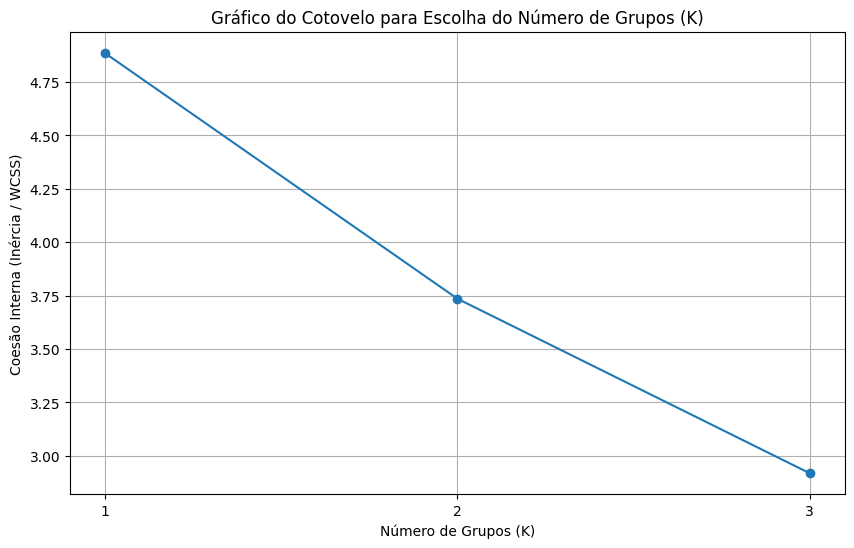

2025-04-21 21:54:20,744 - INFO - Preparação da rodada 1 concluída. Analise o gráfico do cotovelo (baseado em 6 textos) para escolher o número de grupos (K).
2025-04-21 21:54:20,744 - INFO - Iniciando agrupamento (clusterização) em 2 grupos para a rodada 1 (prefixo: 'subcluster_').
2025-04-21 21:54:20,746 - INFO - Agrupando 6 textos em 2 grupos (K-Means)...
2025-04-21 21:54:20,749 - INFO - Agrupamento K-Means concluído. 6 textos foram atribuídos a grupos.
2025-04-21 21:54:20,749 - INFO - Coluna de resultados 'subcluster_1' adicionada/atualizada.
2025-04-21 21:54:20,752 - INFO - Agrupamento da rodada 1 (prefixo 'subcluster_') concluído com sucesso. Resultados na coluna 'subcluster_1'.



Clusterizando o subcluster com K=2...
Subclusterização concluída. Coluna 'subcluster_1' adicionada ao DataFrame 'sub_cf.df'.


,id,subcluster_1,texto_documento
0,1,1,O juiz determinou o pagamento da indenização.
1,2,0,Recurso de apelação foi interposto pela defesa.
2,3,0,A sentença julgou procedente o pedido do autor.
3,4,0,A corte negou provimento ao recurso especial.
5,6,0,Acordo homologado entre as partes.
6,7,1,Indenização por danos morais foi concedida.


In [12]:
print("Preparando o subcluster...")
# Usamos a mesma coluna de texto original. limite_k pode ser menor.
# O gráfico do cotovelo será exibido para o subcluster.
sub_cf.preparar(coluna_textos='texto_documento', limite_k=3, plotar_cotovelo=True)

# Supondo que o cotovelo para o subcluster sugira K=2
k_subcluster = 2
print(f"\nClusterizando o subcluster com K={k_subcluster}...")
nome_coluna_subcluster = sub_cf.clusterizar(num_clusters=k_subcluster)

print(f"Subclusterização concluída. Coluna '{nome_coluna_subcluster}' adicionada ao DataFrame 'sub_cf.df'.")
display(sub_cf.df[['id', nome_coluna_subcluster, 'texto_documento']])

## 11. Resetando o Estado

Se quisermos recomeçar a análise no DataFrame original (por exemplo, tentar um K diferente na primeira rodada) sem perder os dados originais, podemos usar `resetar`.

Isso remove todas as colunas de cluster (`cluster_*`, `subcluster_*`) e a coluna de classificação (`classificacao`) da instância original `cf`.

In [13]:
print("Estado do DataFrame 'cf' ANTES do reset:")
display(cf.df.head())

cf.resetar()

print("\nEstado do DataFrame 'cf' DEPOIS do reset (colunas de cluster/classificação removidas):")
display(cf.df.head())

Estado do DataFrame 'cf' ANTES do reset:


,id,texto_documento,cluster_1,classificacao
0,1,O juiz determinou o pagamento da indenização.,2,Procedente/Indenização
1,2,Recurso de apelação foi interposto pela defesa.,2,Procedente/Indenização
2,3,A sentença julgou procedente o pedido do autor.,0,Procedente/Indenização
3,4,A corte negou provimento ao recurso especial.,2,Procedente/Indenização
4,5,Processo arquivado por falta de movimentação.,1,Recurso/Extinção


2025-04-21 21:54:30,224 - WARNING - Iniciando reinicialização do estado do ClusterFacil (Prefixo: 'cluster_', Coluna Classificação: 'classificacao')...
2025-04-21 21:54:30,226 - INFO - Colunas de resultados anteriores removidas: ['cluster_1', 'classificacao']
2025-04-21 21:54:30,226 - INFO - Estado do ClusterFacil reiniciado. Rodada definida para 1. Chame 'preparar' novamente para começar uma nova análise.



Estado do DataFrame 'cf' DEPOIS do reset (colunas de cluster/classificação removidas):


,id,texto_documento
0,1,O juiz determinou o pagamento da indenização.
1,2,Recurso de apelação foi interposto pela defesa.
2,3,A sentença julgou procedente o pedido do autor.
3,4,A corte negou provimento ao recurso especial.
4,5,Processo arquivado por falta de movimentação.


--- 

Fim do exemplo detalhado!